<a href="https://colab.research.google.com/github/amedyukhina/AgrifieldNet/blob/main/agrinet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AgrifieldNet India Competition

In [1]:
import os
import json
import getpass
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm
from radiant_mlhub import Dataset
import tarfile
import shutil
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.utils.data
from torch import nn
from skimage import io
from torchvision import transforms as torch_transforms
import pylab as plt
from PIL import Image
from skimage.segmentation import mark_boundaries
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.losses import DiceLoss, DiceCELoss, MaskedDiceLoss
from monai.metrics import DiceMetric
import plotly.graph_objects as go
# from torch.utils.tensorboard import SummaryWriter

/home/anna/anaconda3/envs/agri/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Specify global parameters

In [2]:
data_dir = 'data'
random_seed = 42

train_df_path = 'train_data.csv'

BAND_NAMES = ['B01', 'B02', 'B03', 'B04','B05', 'B06', 'B07', 
              'B08','B8A', 'B09', 'B11', 'B12']

In [3]:
np.random.seed(random_seed)

## Download data from MLHUB


In [4]:
collection_name = 'ref_agrifieldnet_competition_v1'

source_collection = f'{collection_name}_source'
train_label_collection = f'{collection_name}_labels_train'
test_label_collection = f'{collection_name}_labels_test'

In [5]:
if not os.path.exists(data_dir):
    os.environ['MLHUB_API_KEY'] =  getpass.getpass(prompt="MLHub API Key: ")

    dataset = Dataset.fetch(collection_name)
    dataset.download(output_dir=data_dir)
    for fn in os.listdir(data_dir):
        with tarfile.open(os.path.join(data_dir, fn)) as f:
            f.extractall(data_dir + '/') 
        os.remove(os.path.join(data_dir, fn))
else:
     print("Dataset already exists")

Dataset already exists


## Create training dataframe

In [6]:
train_paths = os.listdir(os.path.join(data_dir, train_label_collection))
train_ids = [fn.split('_')[-1] for fn in train_paths if 'labels_train' in fn]

field_paths = [f'{data_dir}/{train_label_collection}/{train_label_collection}_{i}/field_ids.tif' 
               for i in train_ids]
label_paths = [f'{data_dir}/{train_label_collection}/{train_label_collection}_{i}/raster_labels.tif' 
               for i in train_ids]
source_paths = [f'{data_dir}/{source_collection}/{source_collection}_{i}/' 
               for i in train_ids]

In [7]:
train_data = pd.DataFrame(np.array([train_ids, field_paths, label_paths, source_paths]).transpose(), 
                          columns=['folder_id', 'field_path', 'label_path', 'source_path'])
train_data.head()

folder_id                                         field_path  \
0     485ab  data/ref_agrifieldnet_competition_v1_labels_tr...   
1     47271  data/ref_agrifieldnet_competition_v1_labels_tr...   
2     1c08c  data/ref_agrifieldnet_competition_v1_labels_tr...   
3     5c4fa  data/ref_agrifieldnet_competition_v1_labels_tr...   
4     200d3  data/ref_agrifieldnet_competition_v1_labels_tr...   

                                          label_path  \
0  data/ref_agrifieldnet_competition_v1_labels_tr...   
1  data/ref_agrifieldnet_competition_v1_labels_tr...   
2  data/ref_agrifieldnet_competition_v1_labels_tr...   
3  data/ref_agrifieldnet_competition_v1_labels_tr...   
4  data/ref_agrifieldnet_competition_v1_labels_tr...   

                                         source_path  
0  data/ref_agrifieldnet_competition_v1_source/re...  
1  data/ref_agrifieldnet_competition_v1_source/re...  
2  data/ref_agrifieldnet_competition_v1_source/re...  
3  data/ref_agrifieldnet_competition_v1_source/re...  
4  data/ref_agrifieldnet_competition_v1_source/re...


## Extract field-crop data

In [8]:
def extract_field_crop_data(data):
    field_ids = []
    crop_types = []
    bands = []

    for i in tqdm(range(len(data))):
        with rasterio.open(data['field_path'].iloc[i]) as src:
            field_data = src.read()[0]
        with rasterio.open(data['label_path'].iloc[i]) as src:
            crop_data = src.read()[0]
        imgs = []
        for band in BAND_NAMES:
            with rasterio.open(data['source_path'].iloc[i] + rf"{band}.tif") as src:
                imgs.append(src.read()[0])

        for field_id in np.unique(field_data)[1:]:
            ind = np.where(field_data == field_id)
            crop_type = np.unique(crop_data[ind])[-1]
            field_ids = field_ids + [field_id] * len(ind[0])
            crop_types = crop_types + [crop_type] * len(ind[0])
            bands.append(np.array([img[ind] for img in imgs]).transpose())
            

    df = pd.DataFrame(np.concatenate(bands), columns=BAND_NAMES)
    df['field_id'] = field_ids
    df['crop_type'] = crop_types
    return df

In [9]:
df = extract_field_crop_data(train_data)

100%|██████████████████████████████████████████████████████████████████████████████████████| 1165/1165 [00:39<00:00, 29.40it/s]


In [10]:
df = df.sort_values(['crop_type', 'field_id']).reset_index(drop=True)

In [11]:
df

B01  B02  B03  B04  B05  B06  B07  B08  B8A  B09  B11  B12  field_id  \
0        45   43   43   49   51   59   67   62   74   12   80   61         1   
1        45   43   44   50   51   59   66   62   73   12   80   61         1   
2        45   42   42   48   49   58   65   61   72   12   80   60         1   
3        45   42   42   47   49   58   65   60   72   12   80   60         1   
4        45   42   43   48   50   57   64   60   71   12   80   62         1   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
188223   46   40   35   29   32   51   62   55   65   11   39   20      7332   
188224   46   40   35   29   32   52   62   55   65   11   38   19      7332   
188225   46   39   35   29   32   52   62   55   65   11   38   19      7332   
188226   46   39   35   29   32   53   63   58   66   11   38   19      7332   
188227   46   40   35   29   32   53   63   59   66   11   38   19      7332   

        crop_type  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
188223         36  
188224         36  
188225         36  
188226         36  
188227         36  

[188228 rows x 14 columns]

## Extract labels

In [12]:
with open(f'{data_dir}/{train_label_collection}/{train_label_collection}'
          f'_{train_data.iloc[0]["folder_id"]}/stac.json') as ll:
    label_json = json.load(ll)

In [13]:
crop_dict = {asset.get('values')[0]:asset.get('summary') 
  for asset in label_json['assets']['raster_labels']['file:values']}
df['crop_label'] = df['crop_type'].apply(lambda x: crop_dict[x])

crop_labels = list(crop_dict.keys())
crop_labels.sort()
crop_names = [crop_dict[key] for key in crop_labels]
for i, (l, n) in enumerate(zip(crop_labels, crop_names)):
    print(i, l, n)

0 1 Wheat
1 2 Mustard
2 3 Lentil
3 4 No Crop
4 5 Green pea
5 6 Sugarcane
6 8 Garlic
7 9 Maize
8 13 Gram
9 14 Coriander
10 15 Potato
11 16 Bersem
12 36 Rice


## Add further indices
https://www.mdpi.com/2072-4292/13/23/4749/htm

In [14]:
df['GCVI'] = df['B08'] / df['B03'] - 1
df['NBR1'] = (df['B08'] - df['B11']) / (df['B08'] + df['B11'])
df['NDTI'] = (df['B11'] - df['B12']) / (df['B11'] + df['B12'])
df['NDVI'] = (df['B08'] - df['B04']) / (df['B08'] + df['B04'])
df['SNDVI'] = (df['B08'] - df['B04']) / (df['B08'] + df['B04'] + 0.16)
ADD_BANDS = ['GCVI', 'NBR1', 'NDTI', 'NDVI', 'SNDVI']

## Plot distributions for all pixels

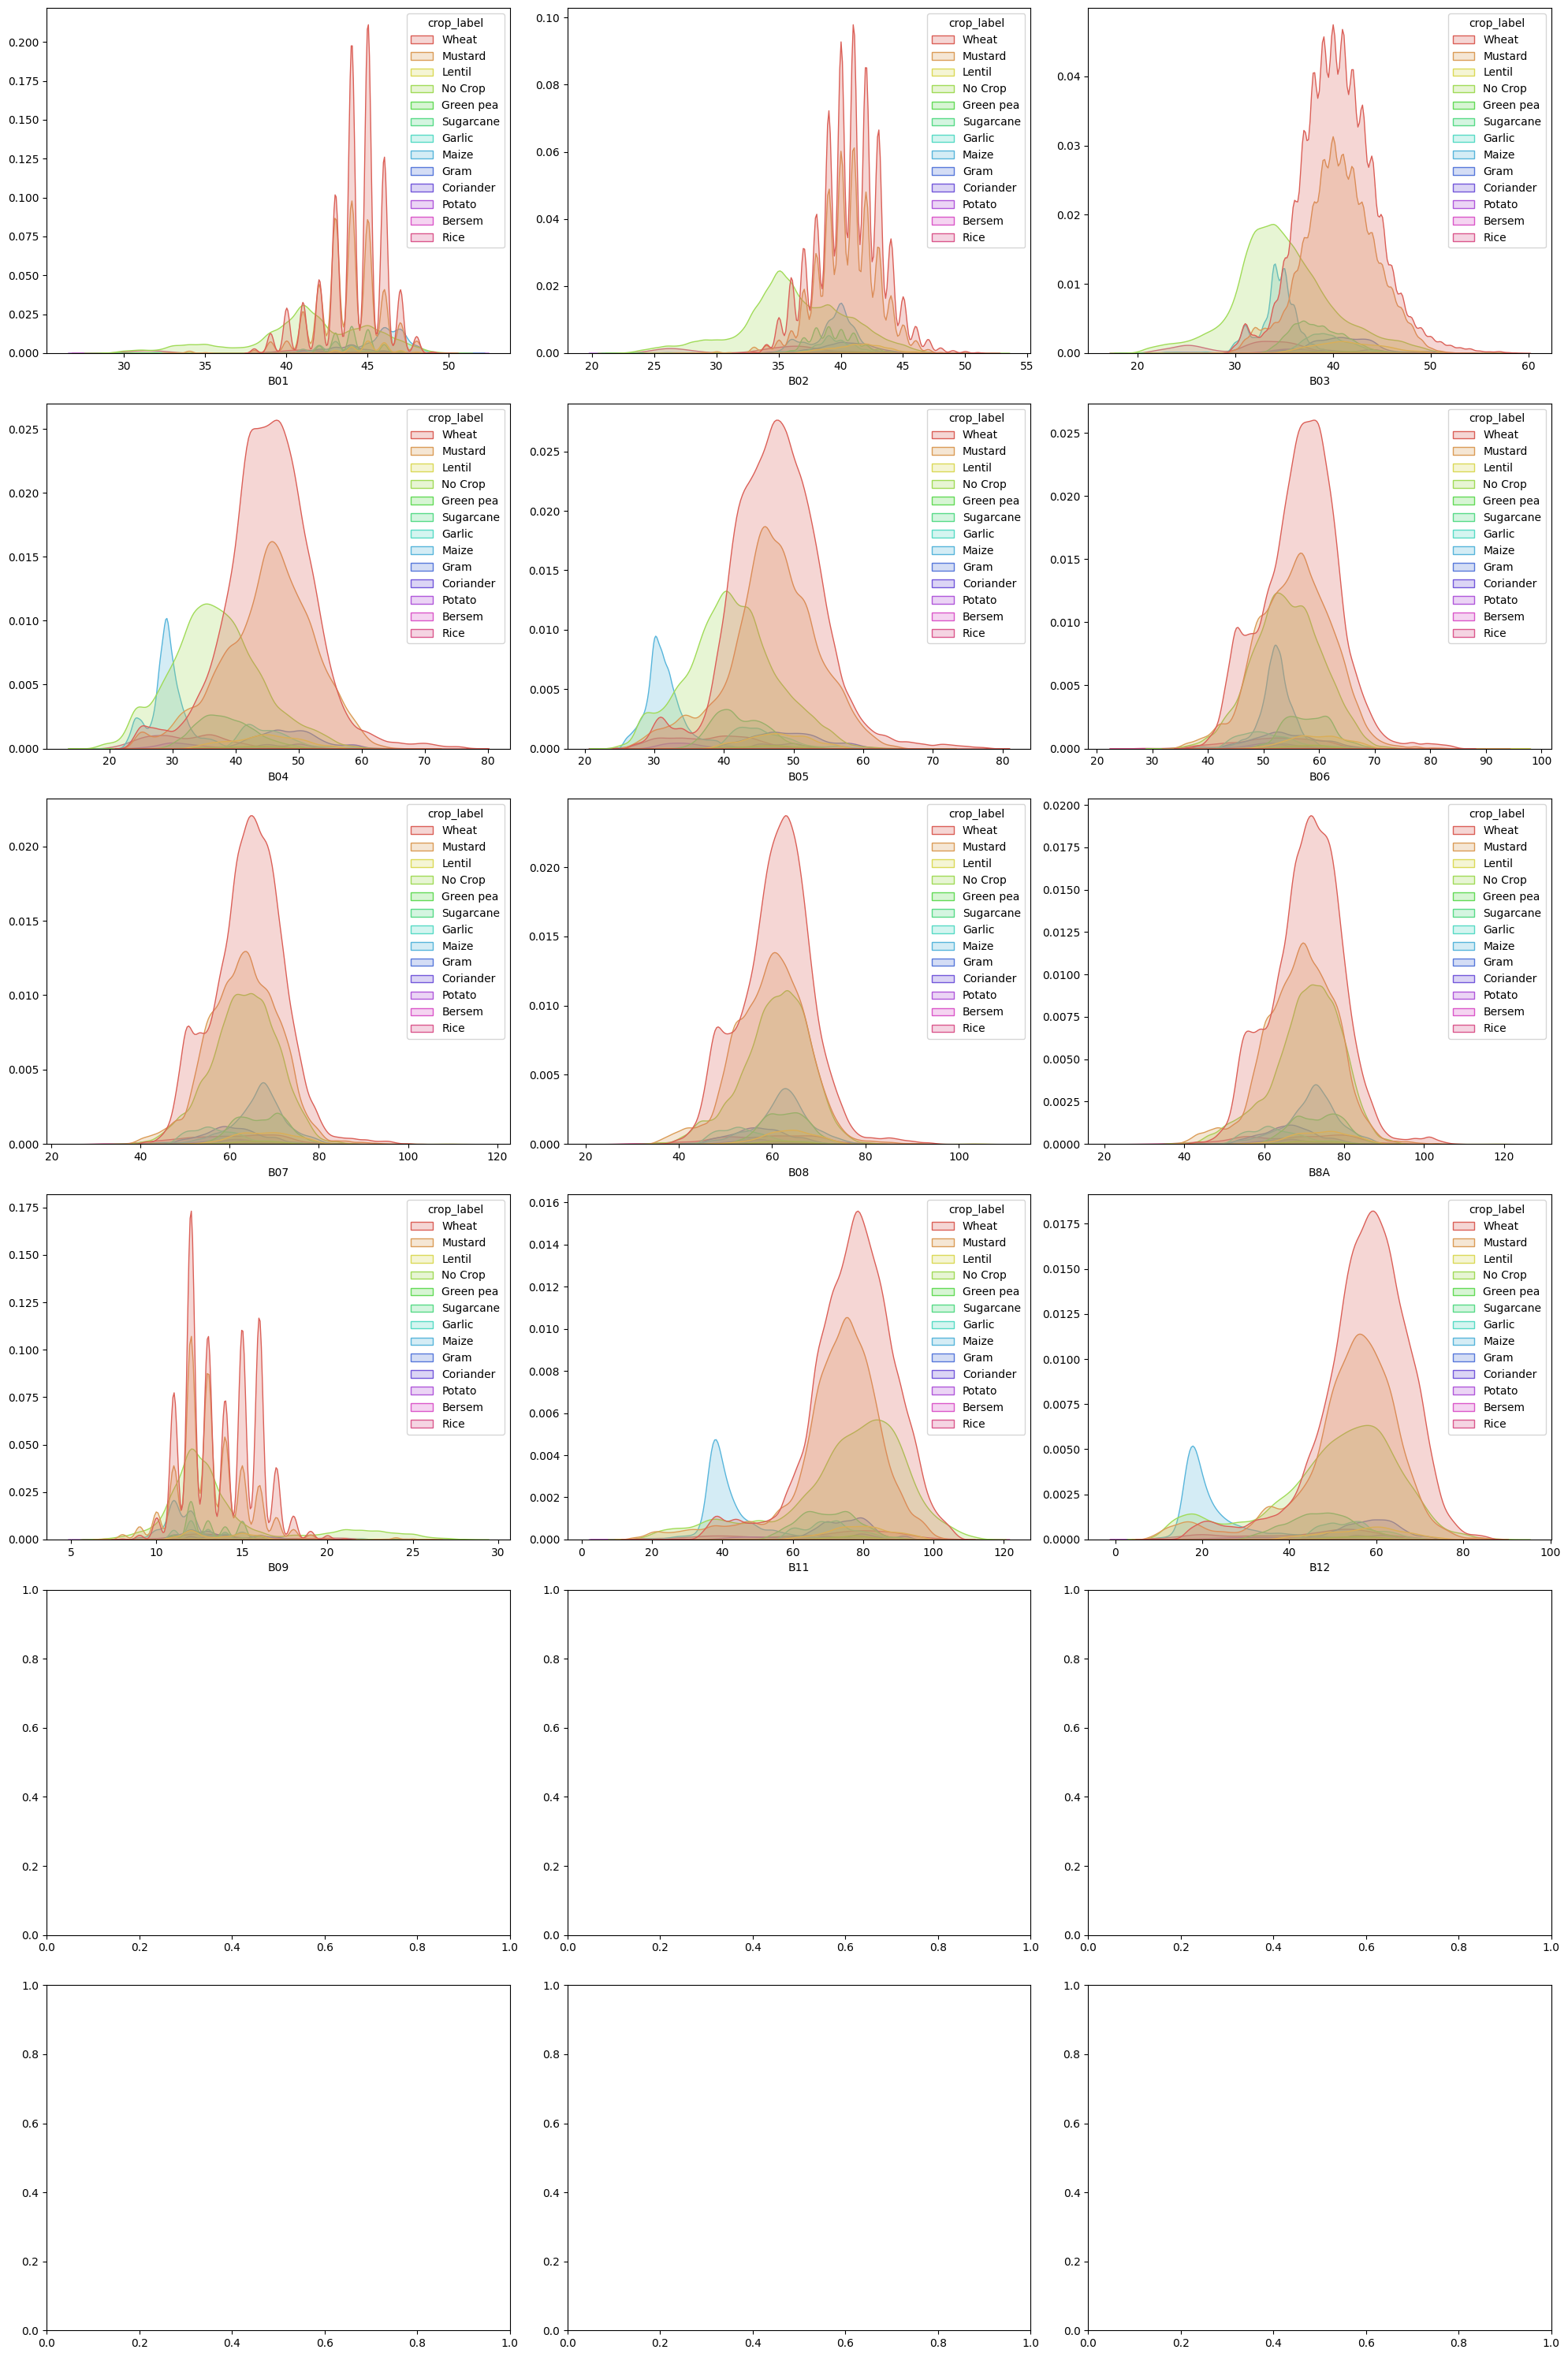

In [15]:
fig, axes = plt.subplots(6, 3, figsize = (20,30))
for ax, band in zip(axes.reshape(-1), BAND_NAMES):
    sns.kdeplot(x = band, hue='crop_label', data = df, 
                fill = True, ax = ax, 
                palette = sns.color_palette('hls', n_colors=13))
    ax.tick_params()
    ax.xaxis.get_label()
    ax.set_ylabel('')
plt.tight_layout()
plt.show()

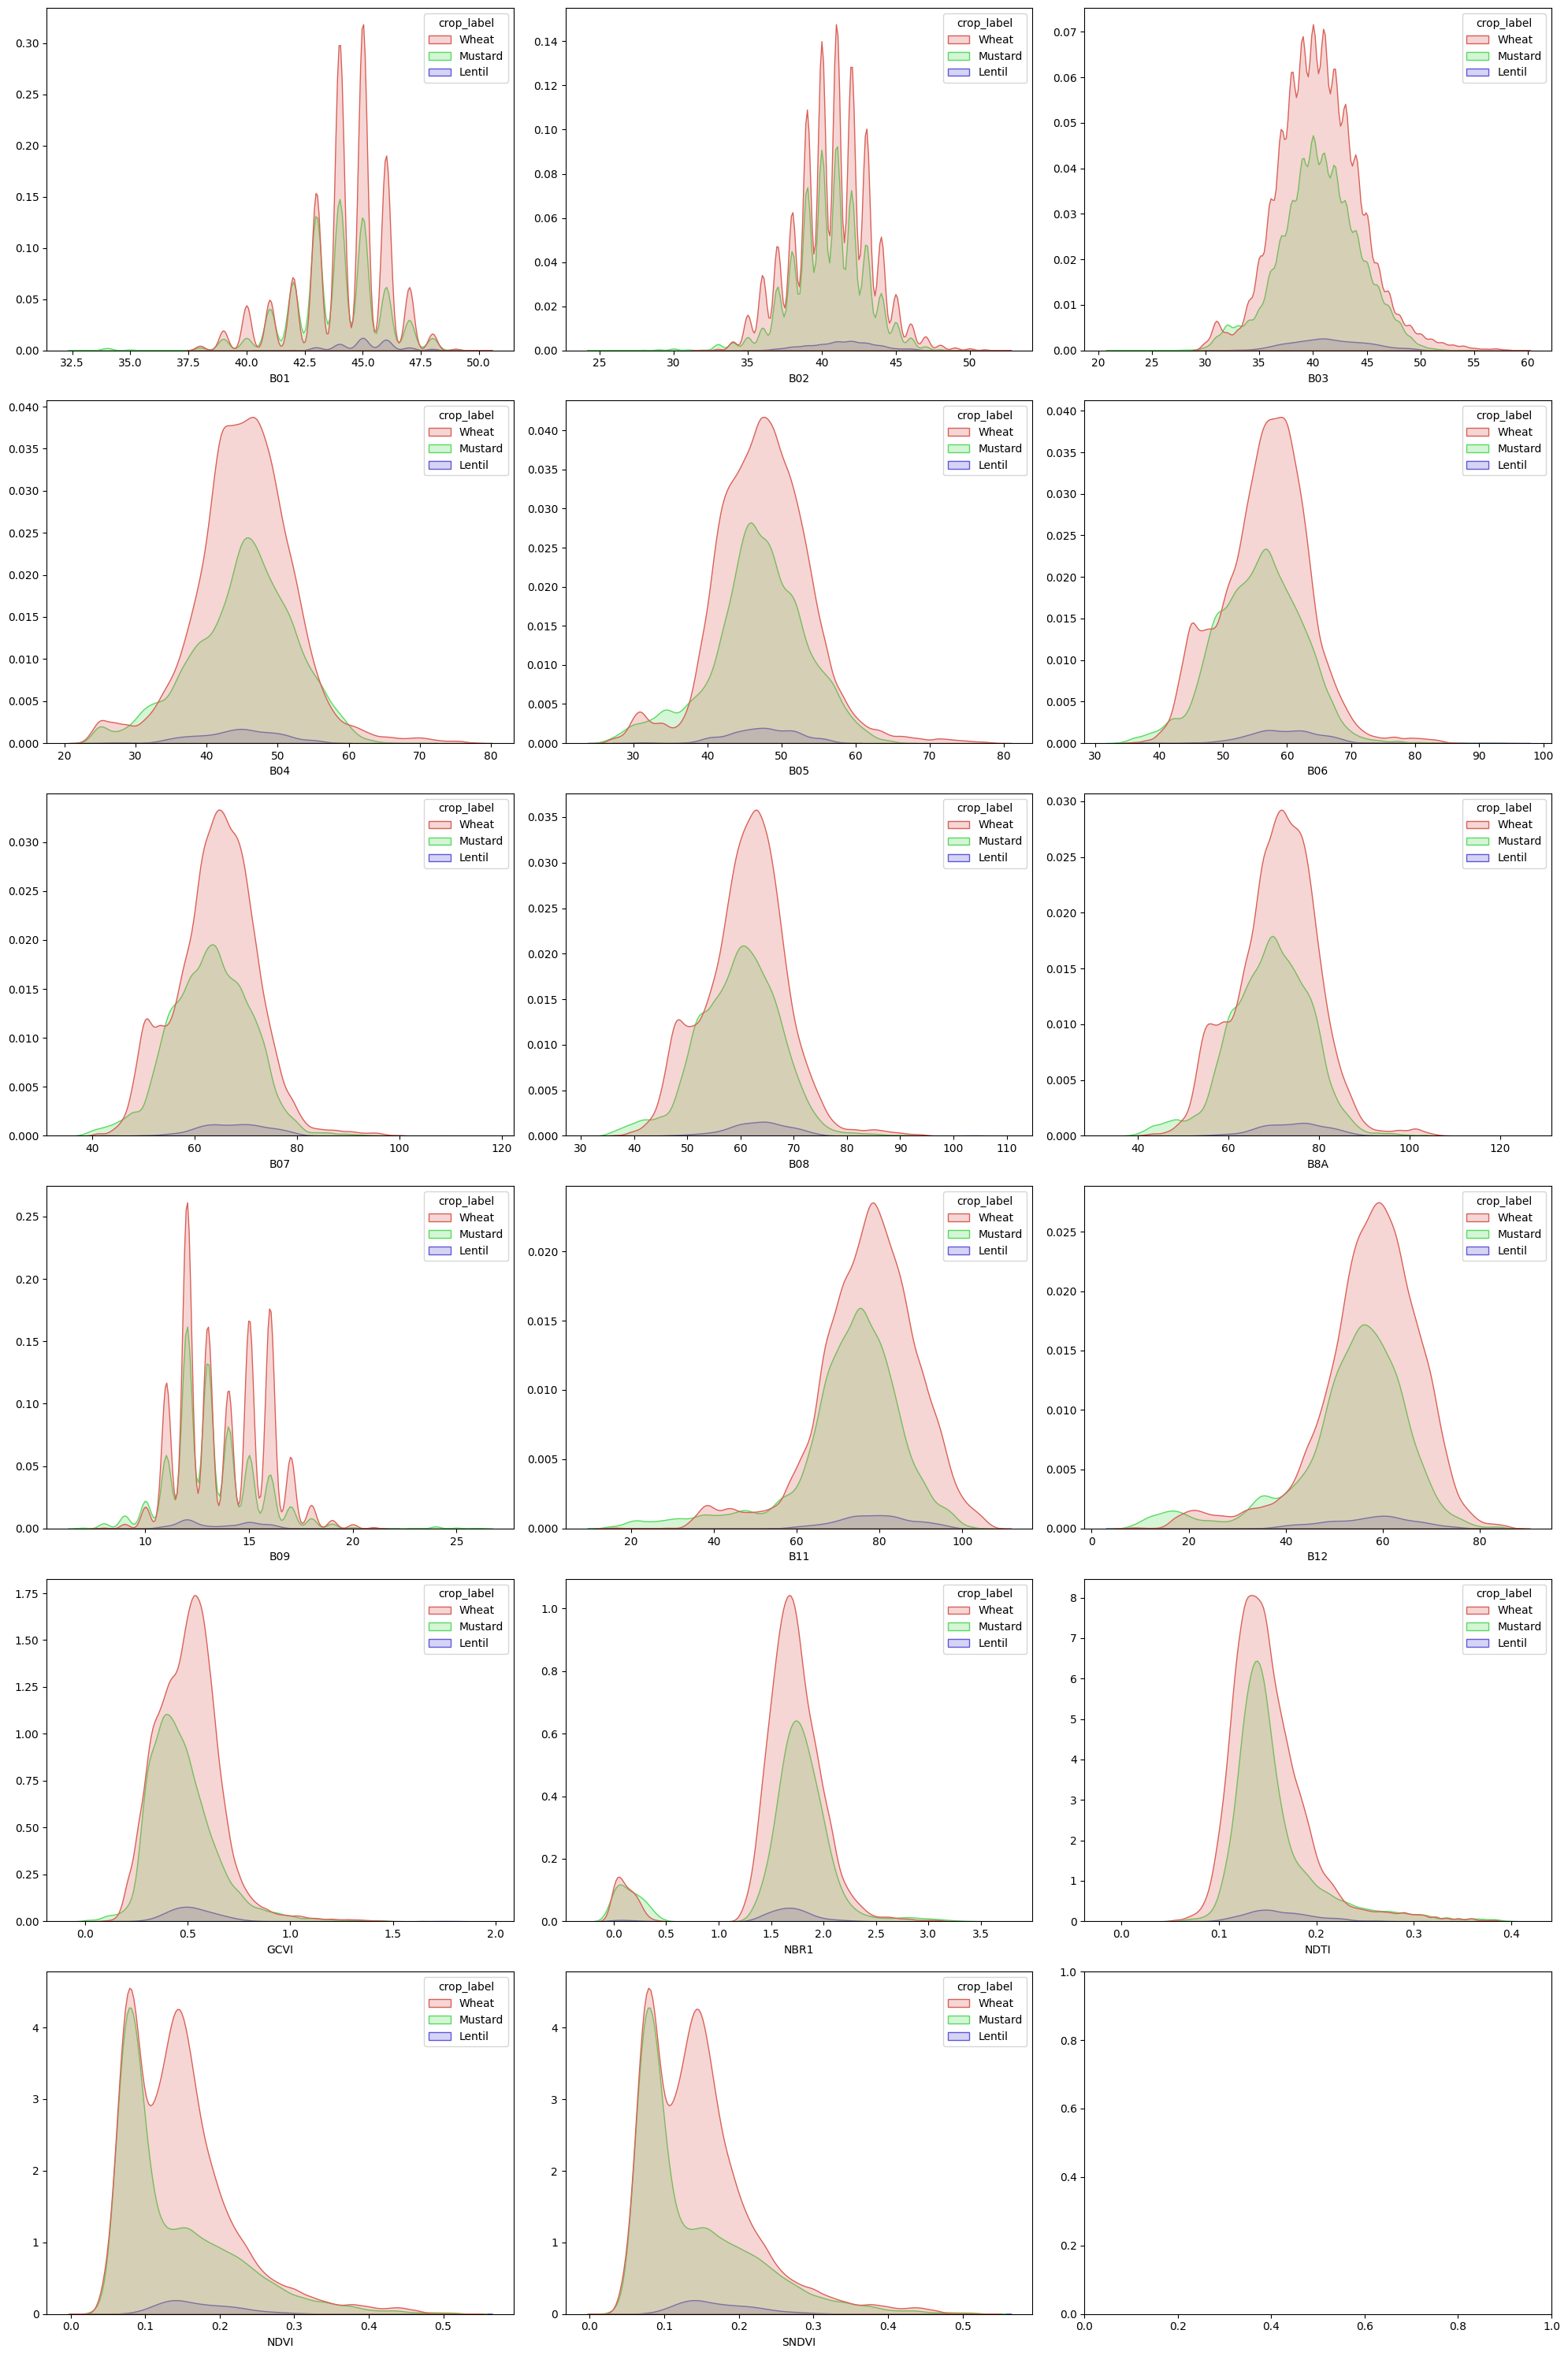

In [16]:
cur_df = df[df['crop_type'].isin([1, 2, 3])]
fig, axes = plt.subplots(6, 3, figsize = (20,30))
for ax, band in zip(axes.reshape(-1), BAND_NAMES + ADD_BANDS):
    sns.kdeplot(x = band, hue='crop_label', data = cur_df, 
                fill = True, ax = ax, 
                palette = sns.color_palette('hls', n_colors=3))
    ax.tick_params()
    ax.xaxis.get_label()
    ax.set_ylabel('')
plt.tight_layout()
plt.show()

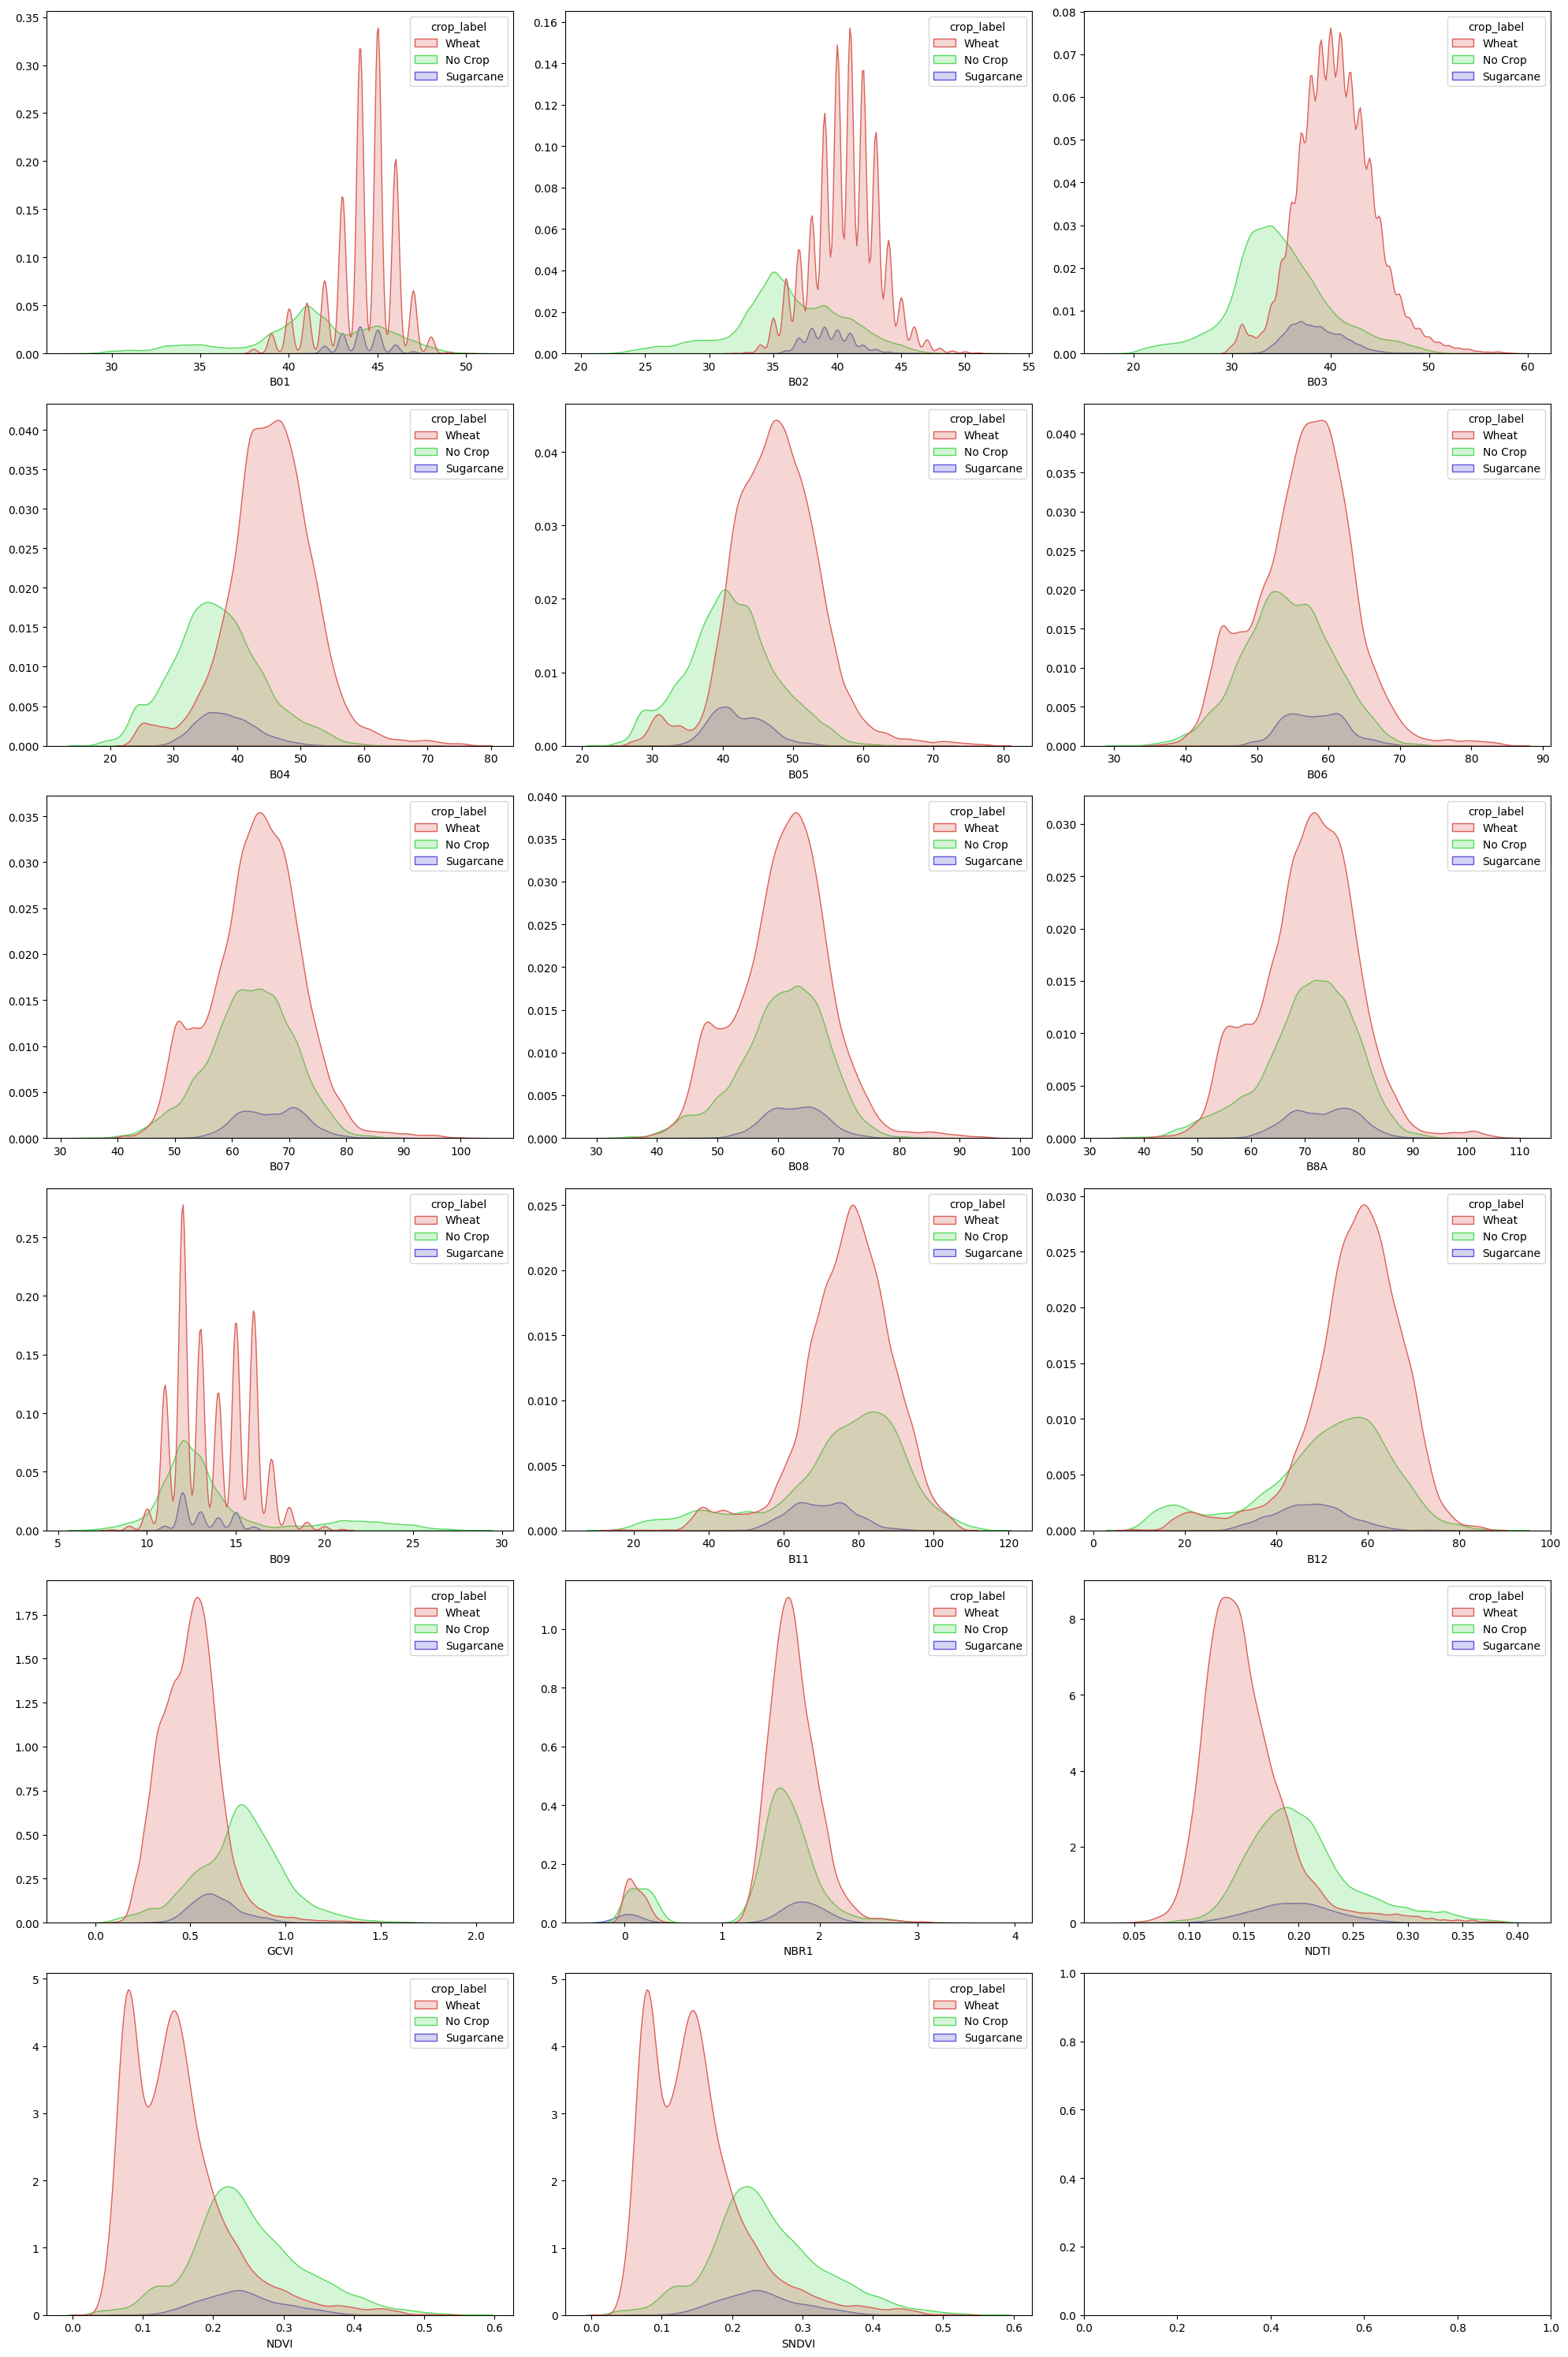

In [17]:
cur_df = df[df['crop_type'].isin([1, 4, 6])]
fig, axes = plt.subplots(6, 3, figsize = (20,30))
for ax, band in zip(axes.reshape(-1), BAND_NAMES + ADD_BANDS):
    sns.kdeplot(x = band, hue='crop_label', data = cur_df, 
                fill = True, ax = ax, 
                palette = sns.color_palette('hls', n_colors=3))
    ax.tick_params()
    ax.xaxis.get_label()
    ax.set_ylabel('')
plt.tight_layout()
plt.show()

## Compute and plot distributions of mean values by field

In [18]:
df_mean = df.groupby('field_id').mean().reset_index()
df_mean['field_area'] = df.groupby('field_id').count().reset_index()['crop_type']
df_mean = df_mean.sort_values(['crop_type', 'field_id']).reset_index(drop=True)
df_mean['crop_label'] = df_mean['crop_type'].apply(lambda x: crop_dict[x])
df_mean

field_id        B01        B02        B03        B04        B05  \
0            1  45.000000  42.444444  42.722222  48.000000  49.666667   
1            2  45.000000  42.000000  42.166667  47.666667  49.250000   
2            3  45.000000  42.687500  43.500000  49.187500  51.437500   
3           10  43.421053  38.578947  37.473684  36.894737  41.157895   
4           14  43.000000  38.714286  37.904762  38.714286  44.000000   
...        ...        ...        ...        ...        ...        ...   
5546      7154  47.000000  40.333333  36.222222  34.666667  37.777778   
5547      7156  46.700000  38.850000  33.900000  29.750000  32.200000   
5548      7206  45.500000  37.187500  32.437500  26.562500  30.187500   
5549      7232  45.200000  37.666667  32.766667  27.783333  30.550000   
5550      7332  46.076923  39.653846  35.230769  29.423077  31.846154   

            B06        B07        B08        B8A  ...        B11        B12  \
0     58.000000  65.222222  60.277778  71.944444  ...  80.277778  61.333333   
1     59.916667  69.000000  63.916667  76.333333  ...  79.916667  56.750000   
2     62.875000  71.625000  66.625000  79.312500  ...  82.125000  58.062500   
3     59.052632  68.578947  65.157895  76.052632  ...  66.842105  45.000000   
4     61.285714  72.619048  68.142857  80.142857  ...  72.428571  46.380952   
...         ...        ...        ...        ...  ...        ...        ...   
5546  49.222222  56.666667  53.222222  61.666667  ...  61.111111  47.000000   
5547  42.700000  48.600000  44.700000  50.100000  ...  31.500000  19.950000   
5548  43.687500  52.312500  47.187500  54.000000  ...  26.312500  14.187500   
5549  39.000000  44.266667  38.966667  43.250000  ...  19.266667  10.633333   
5550  49.615385  58.615385  53.346154  60.923077  ...  35.538462  18.615385   

      crop_type      GCVI      NBR1      NDTI      NDVI     SNDVI  field_area  \
0           1.0  0.410934  1.679238  0.133807  0.113383  0.113215          18   
1           1.0  0.516696  1.668952  0.169812  0.145935  0.145725          12   
2           1.0  0.533434  1.618109  0.172177  0.151548  0.151337          16   
3           1.0  0.741809  1.412814  0.195686  0.277719  0.277283          19   
4           1.0  0.800794  1.168101  0.220480  0.275889  0.275476          21   
...         ...       ...       ...       ...       ...       ...         ...   
5546       36.0  0.467833  1.365196  0.137216  0.210567  0.210182           9   
5547       36.0  0.318252  0.180191  0.227143  0.195904  0.195490          20   
5548       36.0  0.456858  0.284042  0.301278  0.275782  0.275190          16   
5549       36.0  0.189749  0.344067  0.289177  0.165388  0.164997          60   
5550       36.0  0.514774  0.200514  0.312710  0.287650  0.287097          26   

      crop_label  
0          Wheat  
1          Wheat  
2          Wheat  
3          Wheat  
4          Wheat  
...          ...  
5546        Rice  
5547        Rice  
5548        Rice  
5549        Rice  
5550        Rice  

[5551 rows x 21 columns]

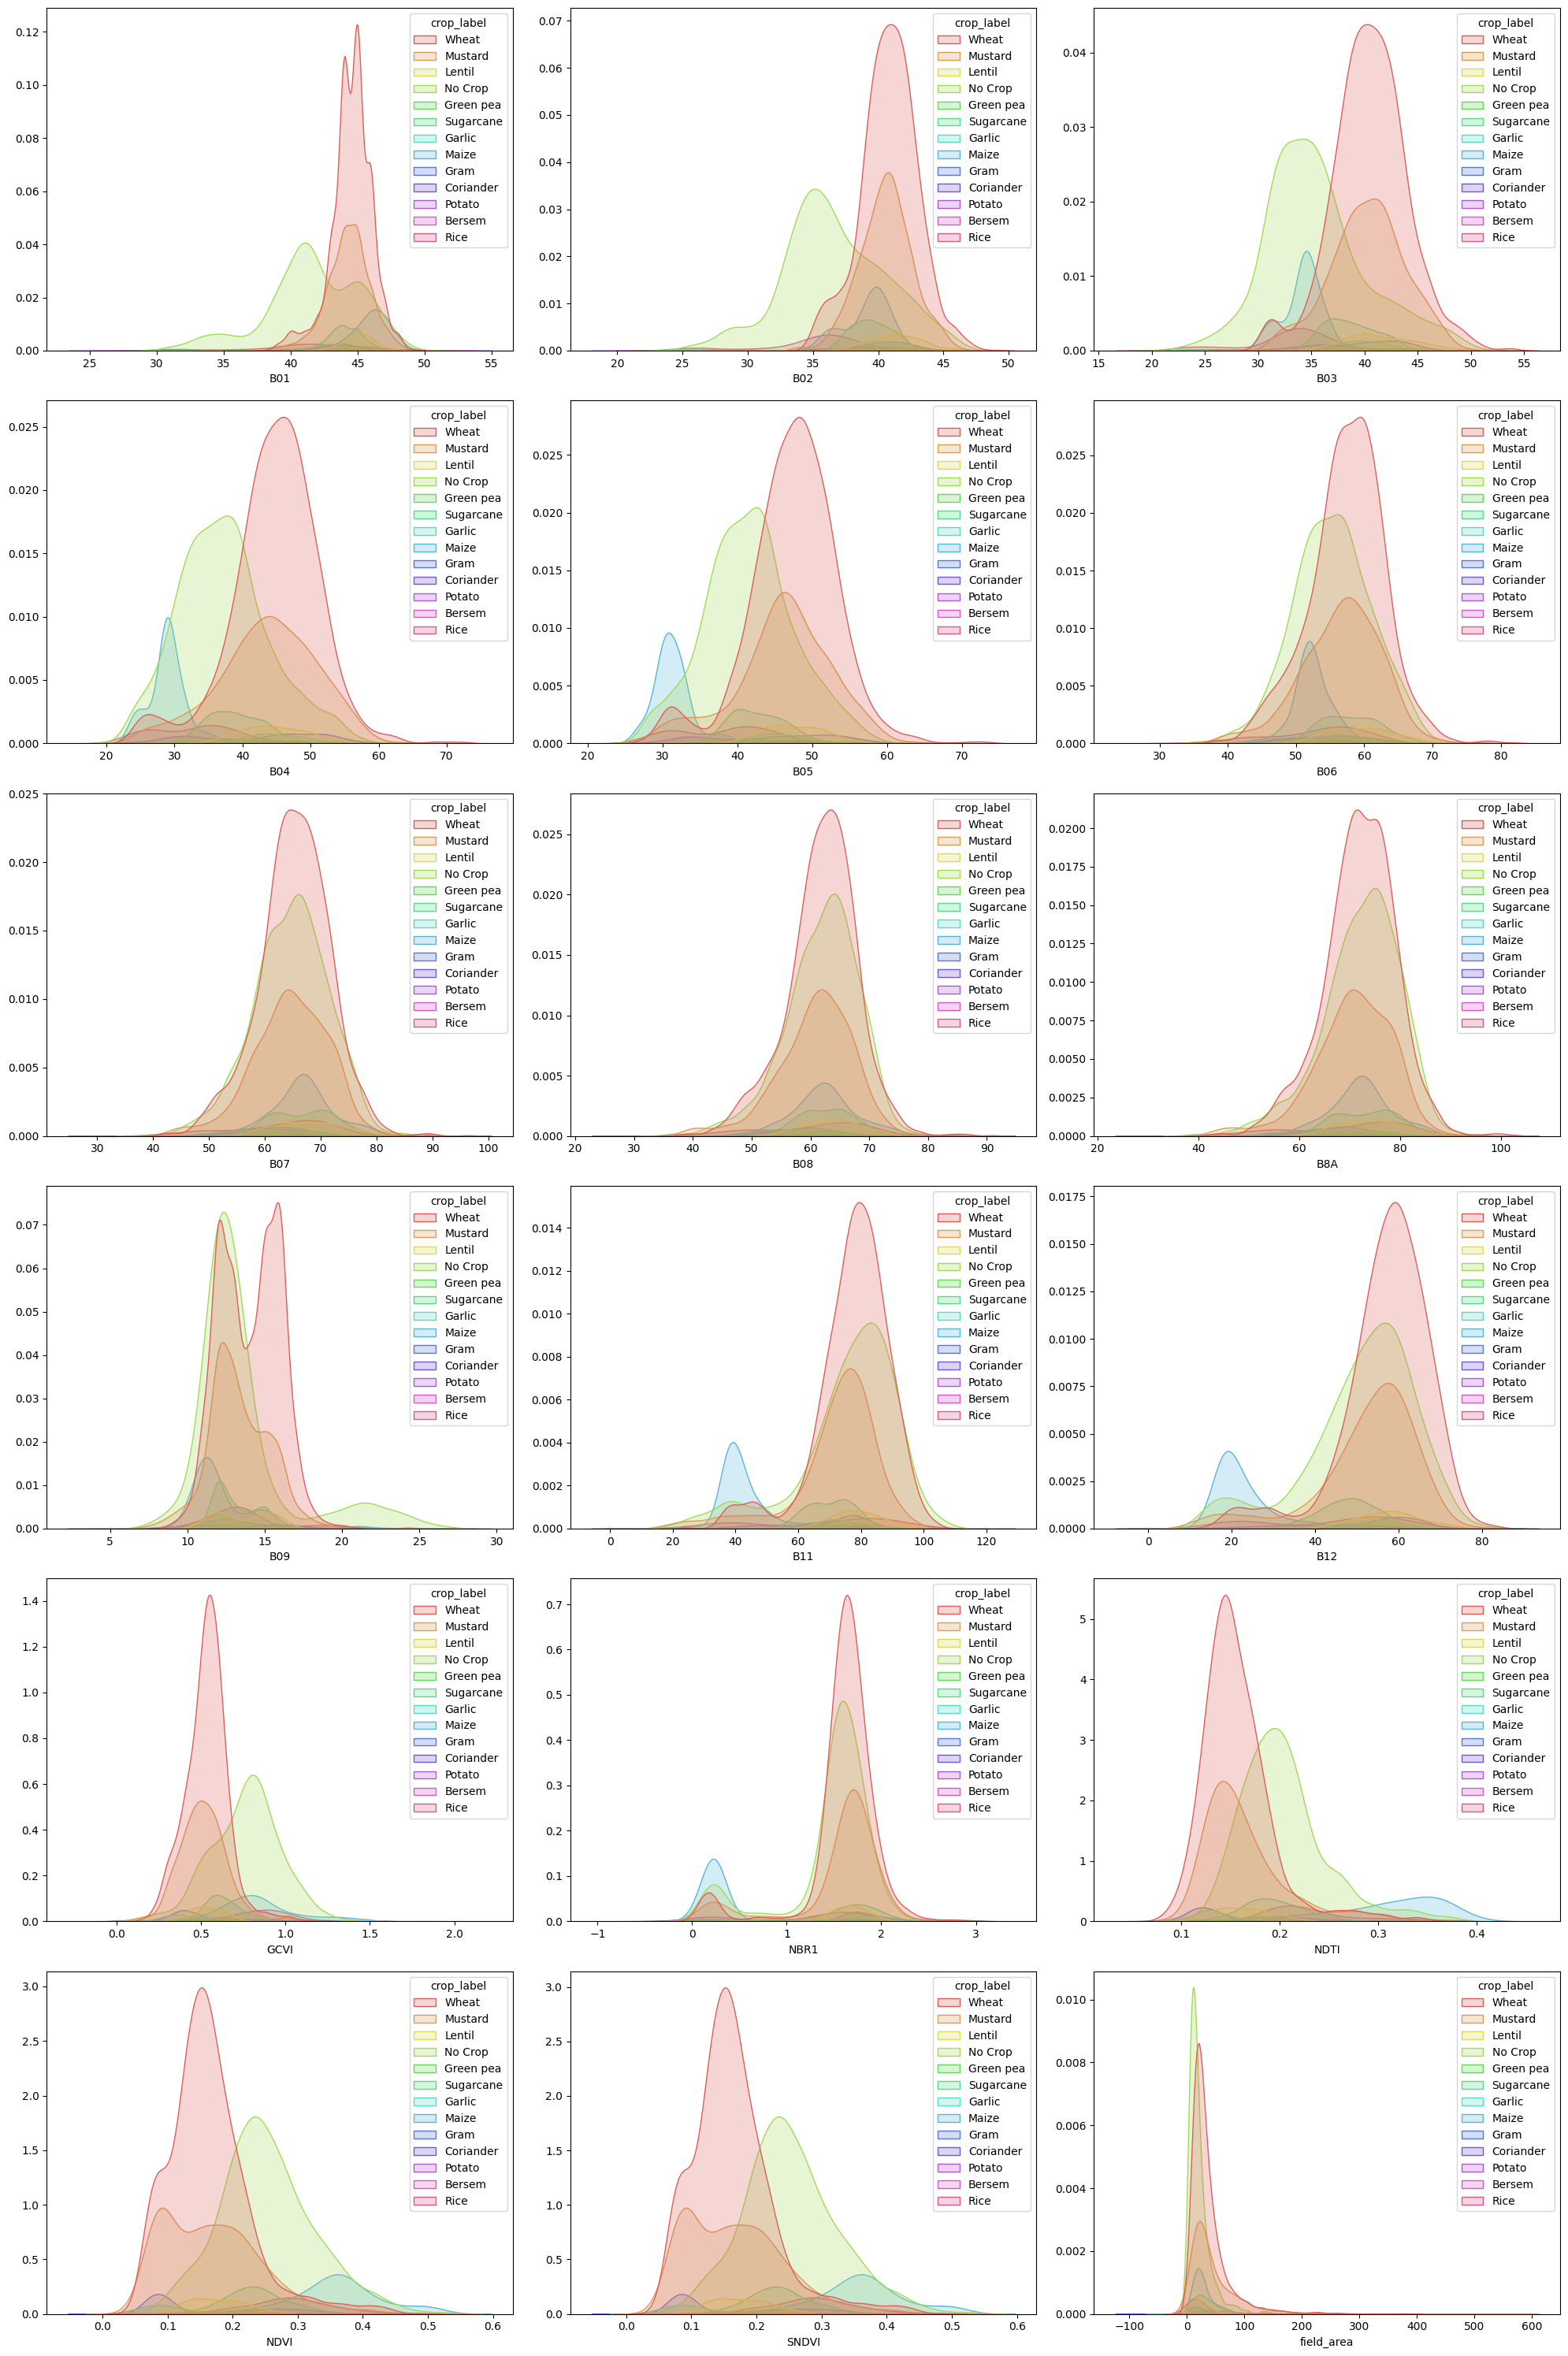

In [19]:
fig, axes = plt.subplots(6, 3, figsize = (20,30))
for ax, band in zip(axes.reshape(-1), BAND_NAMES + ADD_BANDS + ['field_area']):
    sns.kdeplot(x = band, hue='crop_label', data = df_mean, 
                fill = True, ax = ax, 
                palette = sns.color_palette('hls', n_colors=13))
    ax.tick_params()
    ax.xaxis.get_label()
    ax.set_ylabel('')
plt.tight_layout()
plt.show()

## Compute standard deviations of features inside each field and plot distributions

In [20]:
df_std = df.groupby('field_id').std().reset_index()
df_std['crop_type'] = df_mean['crop_type']
df_std = df_std.sort_values(['crop_type', 'field_id']).reset_index(drop=True)
df_std['crop_label'] = df_std['crop_type'].apply(lambda x: crop_dict[x])
df_std

field_id       B01       B02       B03       B04       B05       B06  \
0            1  0.000000  0.511310  0.669113  1.137593  0.766965  0.766965   
1            2  0.000000  0.738549  1.029857  1.969464  1.422226  0.668558   
2            3  0.000000  1.250000  1.712698  3.563121  2.337199  0.885061   
3            4  0.351866  0.915475  1.897367  2.576450  2.231805  0.703732   
4            5  0.000000  0.576344  0.726150  1.215464  0.484367  0.849950   
...        ...       ...       ...       ...       ...       ...       ...   
5546      7326  0.496139  0.979796  1.553656  2.911251  1.953301  1.764609   
5547      7327  0.000000  0.533761  0.791695  0.974022  0.668800  2.774015   
5548      7328  0.000000  0.307794  0.307794  0.670820  0.604805  0.502625   
5549      7331  0.486985  0.625543  0.868873  1.507557  1.437774  1.265224   
5550      7332  0.271746  0.485165  0.429669  0.577794  0.367946  1.768093   

           B07       B08       B8A       B09       B11       B12  crop_type  \
0     1.003263  1.447332  1.161754  0.000000  0.669113  0.907485        1.0   
1     0.953463  0.668558  0.492366  0.389249  1.729862  2.490893        1.0   
2     0.619139  1.310216  0.478714  0.000000  2.963669  3.549061        1.0   
3     0.351866  0.507093  0.516398  0.457738  1.121224  2.563480        1.0   
4     1.146626  1.360638  1.580404  0.477119  0.802508  0.551632        1.0   
...        ...       ...       ...       ...       ...       ...        ...   
5546  3.264730  3.561547  4.627676  0.508391  5.803977  6.305065       36.0   
5547  4.440810  4.779169  5.665912  0.423659  1.508759  1.188741       36.0   
5548  1.356272  1.959457  1.559352  0.000000  1.050063  1.555973       36.0   
5549  3.536931  4.131246  4.610951  0.000000  4.165072  5.640410       36.0   
5550  2.515185  3.610455  3.084452  0.508391  2.928901  1.768093       36.0   

          GCVI      NBR1      NDTI      NDVI     SNDVI crop_label  
0     0.026338  0.016607  0.007117  0.006353  0.006344      Wheat  
1     0.042533  0.032151  0.013016  0.021753  0.021718      Wheat  
2     0.057006  0.055223  0.013588  0.034946  0.034890      Wheat  
3     0.072982  0.020779  0.016581  0.029694  0.029646      Wheat  
4     0.047056  0.020522  0.007210  0.020519  0.020490      Wheat  
...        ...       ...       ...       ...       ...        ...  
5546  0.154516  0.603312  0.049290  0.061315  0.061207       Rice  
5547  0.183255  0.032885  0.019107  0.048890  0.048830       Rice  
5548  0.060354  0.023669  0.024766  0.020980  0.020951       Rice  
5549  0.150367  0.073150  0.063358  0.049584  0.049515       Rice  
5550  0.109177  0.036572  0.017709  0.038635  0.038580       Rice  

[5551 rows x 20 columns]

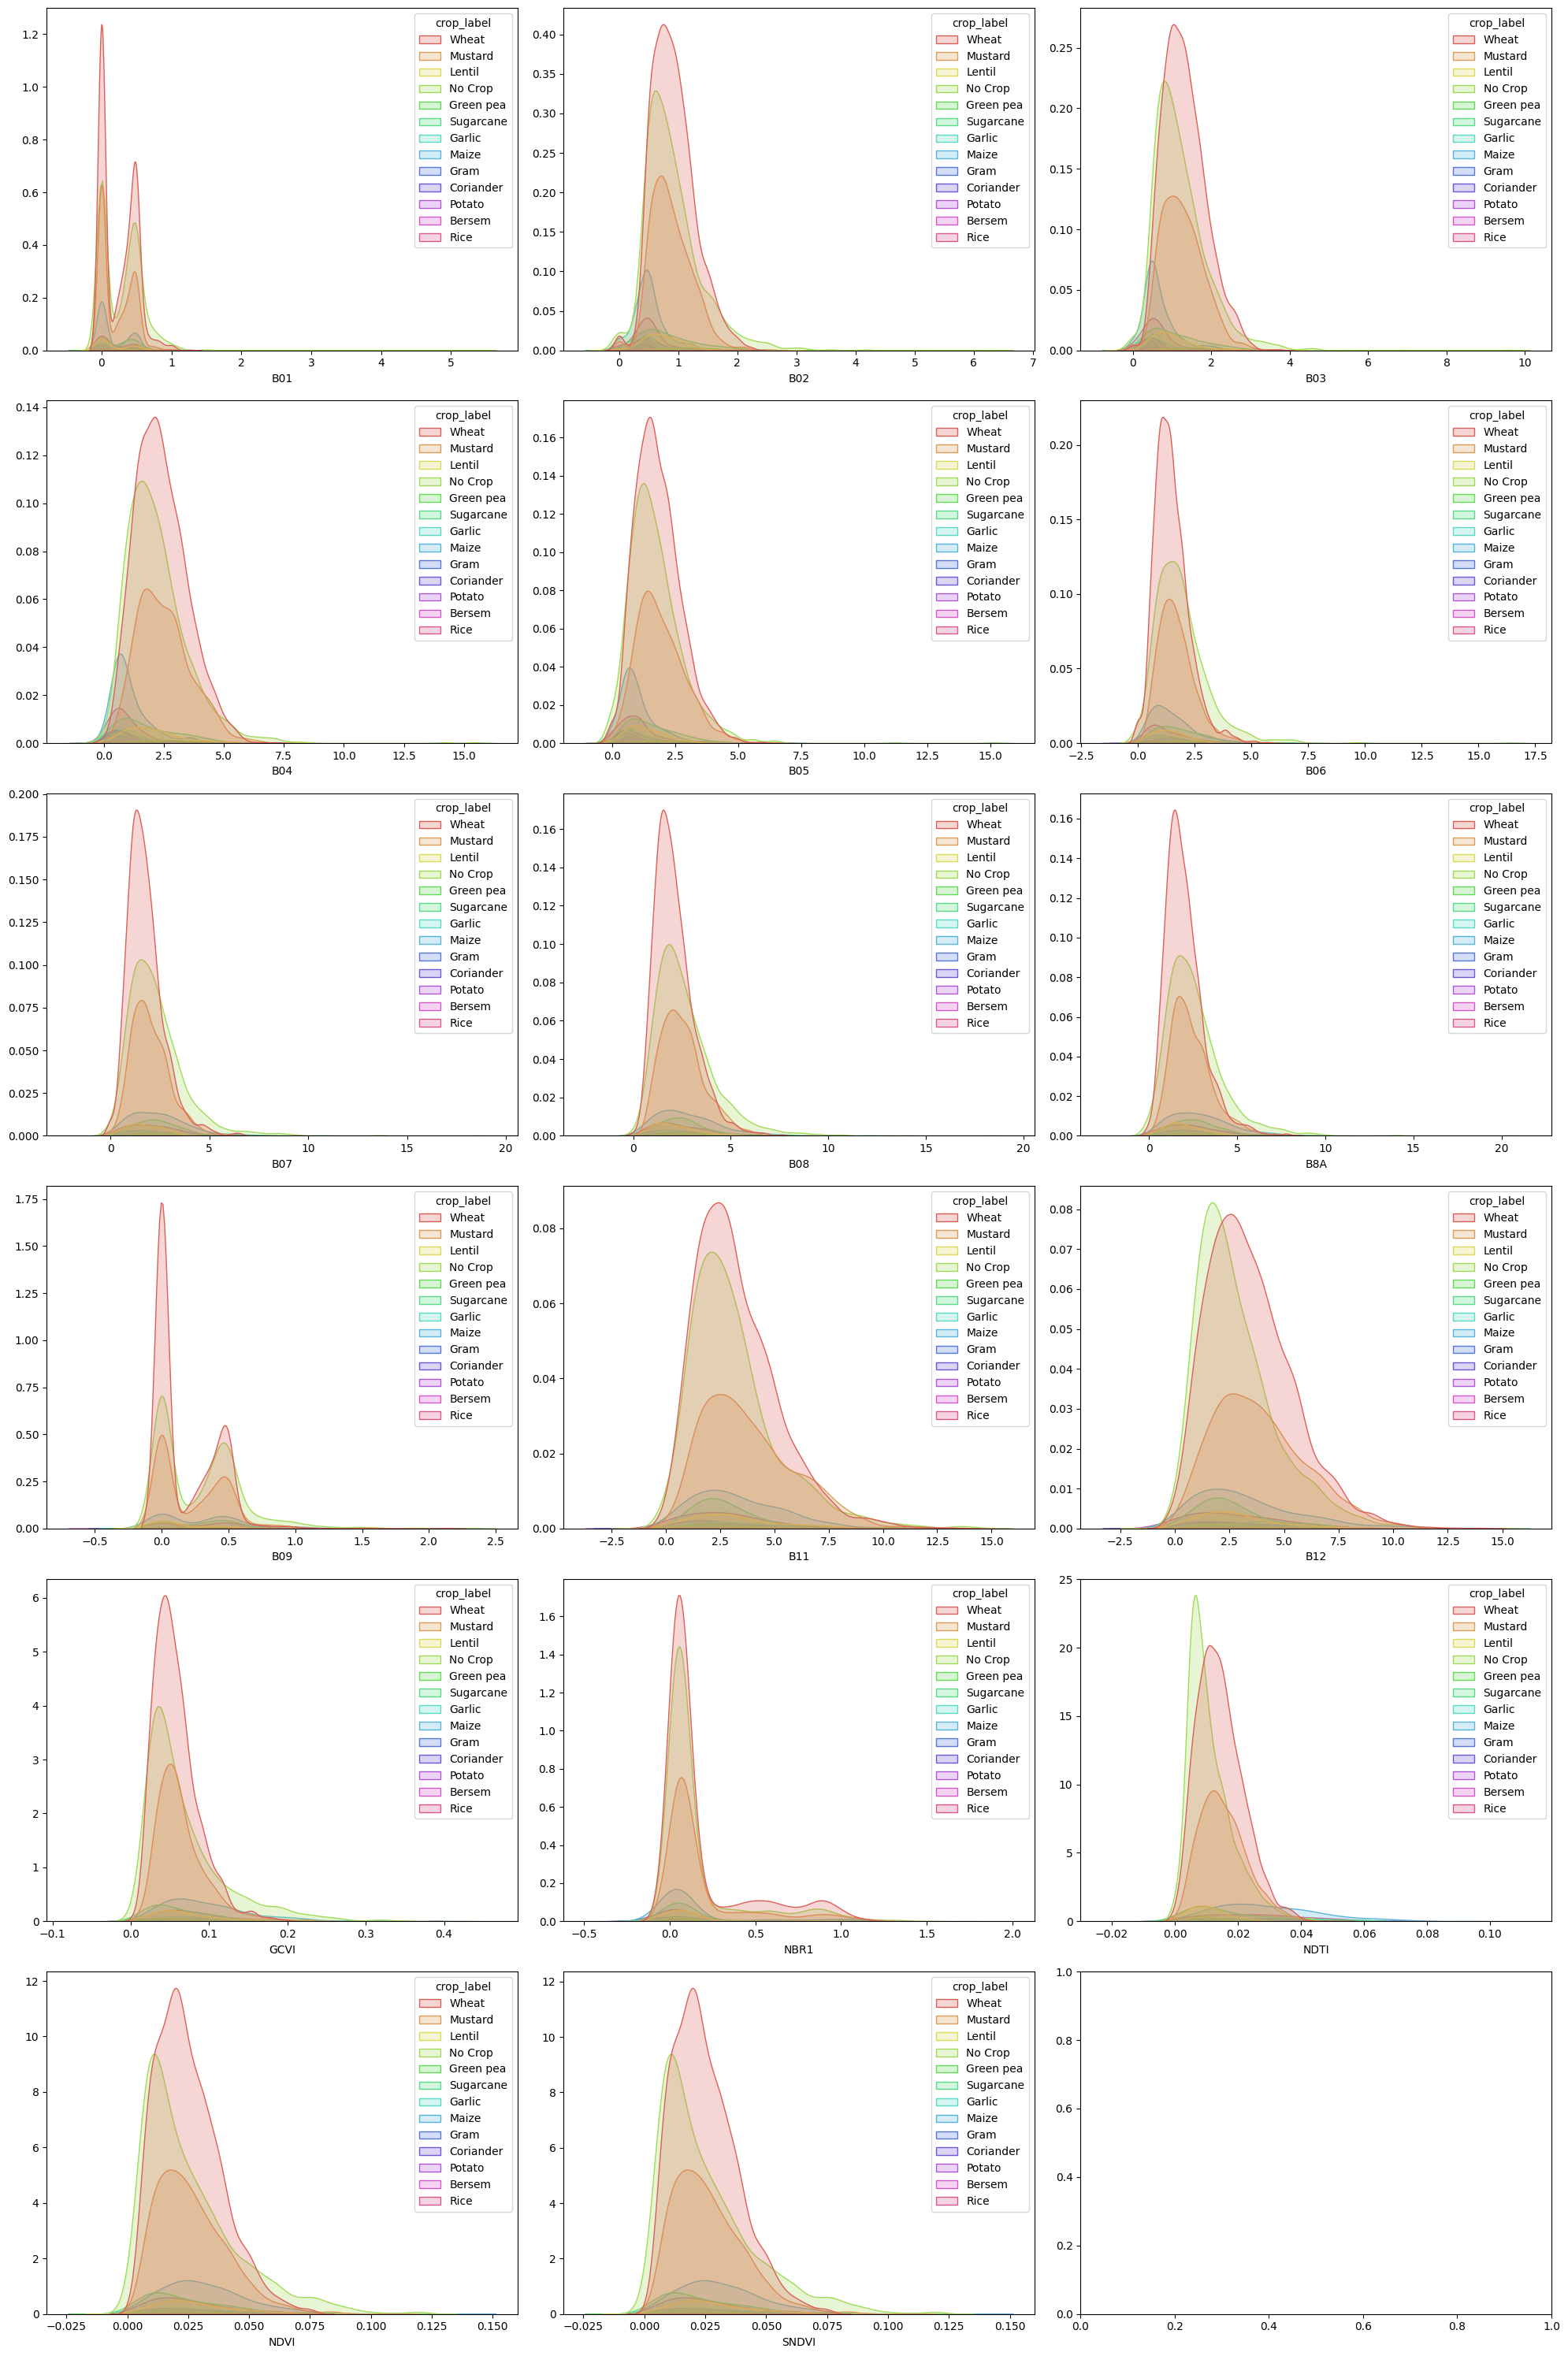

In [21]:
fig, axes = plt.subplots(6, 3, figsize = (20,30))
for ax, band in zip(axes.reshape(-1), BAND_NAMES + ADD_BANDS ):
    sns.kdeplot(x = band, hue='crop_label', data = df_std, 
                fill = True, ax = ax, 
                palette = sns.color_palette('hls', n_colors=13))
    ax.tick_params()
    ax.xaxis.get_label()
    ax.set_ylabel('')
plt.tight_layout()
plt.show()

## Compute correlations

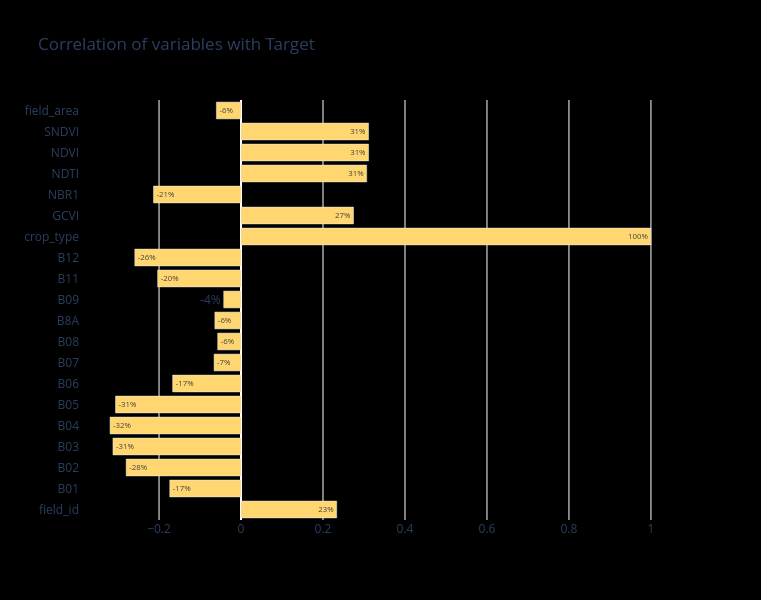

In [26]:
palette = cycle(["#ffd670","#70d6ff","#ff4d6d","#8338ec","#90cf8e"])
targ = df_mean.corrwith(df_mean['crop_type'], axis=0)
val = [str(round(v*100)) + '%' for v in targ.values]
fig = go.Figure()
fig.add_trace(go.Bar(y=targ.index, x= targ.values, orientation='h',text = val, marker_color = next(palette)))
fig.update_layout(title = "Correlation of variables with Target",width = 1200, height = 600,
                  paper_bgcolor='rgb(0,0,0,0)',plot_bgcolor='rgb(0,0,0,0)')

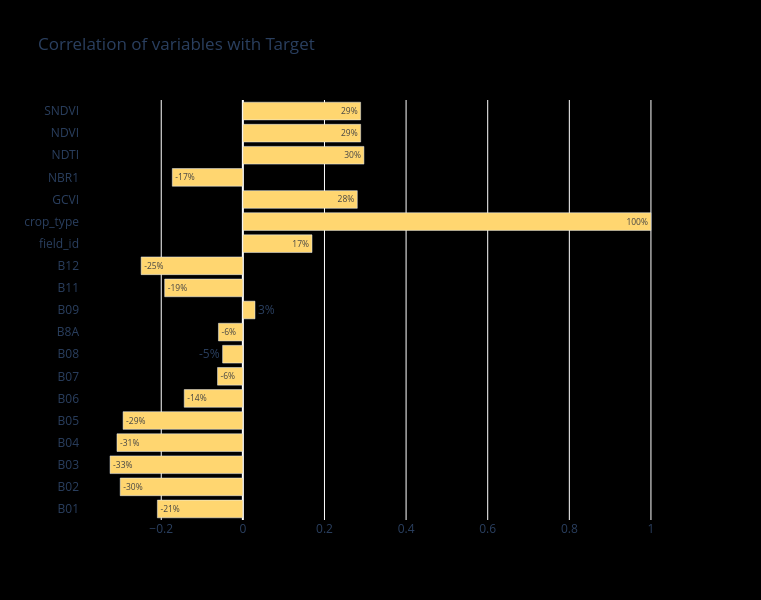

In [27]:
palette = cycle(["#ffd670","#70d6ff","#ff4d6d","#8338ec","#90cf8e"])
targ = df.corrwith(df['crop_type'], axis=0)
val = [str(round(v*100)) + '%' for v in targ.values]
fig = go.Figure()
fig.add_trace(go.Bar(y=targ.index, x= targ.values, orientation='h',text = val, marker_color = next(palette)))
fig.update_layout(title = "Correlation of variables with Target",width = 1200, height = 600,
                  paper_bgcolor='rgb(0,0,0,0)',plot_bgcolor='rgb(0,0,0,0)')